In [2]:
#importing standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.multitest as smm
import warnings
#suppress warnings
warnings.filterwarnings('ignore')
%matplotlib inline  

#reading the data: /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement Ziza 2014/Clement-Ziza processed.tsv
data = pd.read_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement Ziza 2014/Clement-Ziza processed.tsv', sep='\t', header=11,index_col=0)
systematic_names = data.index

In [3]:
#not entirely obvious what the antisense data is, so I will just ignore this for the moment
#reading the data: /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement Ziza 2014/Clement-Ziza antisense.tsv
#antisense = pd.read_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement Ziza 2014/Clement-Ziza antisense.tsv', sep='\t', header=17,index_col=0)
#load the proper gene desc map /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/gene_IDs_names_products.tsv
gene_desc = pd.read_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/gene_IDs_names_products.tsv', sep='\t', header=None,)
#indices=[]
#for i in antisense.index:
#    if i in gene_desc[0].values:
#        #if there is a value in the second column, that is not nan
#        if str(gene_desc[gene_desc[0]==i][2].values[0])!='nan':
            
#            indices.append(gene_desc[gene_desc[0]==i][2].values[0])
#        else:
#           indices.append(i)
            
#   else:
#           indices.append(i)
            
#antisense.index=indices



#do same for data
indices_=[]
for i in data.index:
    if i in gene_desc[0].values:
        #if there is a value in the second column, that is not nan
        if str(gene_desc[gene_desc[0]==i][2].values[0])!='nan':
            
            indices_.append(gene_desc[gene_desc[0]==i][2].values[0])
        else:
            indices_.append(i)
            
    else:
            indices_.append(i)
            
data.index=indices_


In [4]:
#add anti to the gene_ids
#antisense.index = ['anti-'+i for i in antisense.index]
#concatenate the two dataframes
#data = pd.concat([data,antisense],axis=0)
data.head()

,sample_01,sample_02,sample_03,sample_04,sample_05,sample_06,sample_07,sample_08,sample_09,sample_10,...,sample_59,sample_60,sample_61,sample_62,sample_63,sample_64,sample_65,sample_66,sample_67,sample_68
mrx11,66,31,42,29,22,74,67,61,78,117,...,110,67,70,85,56,30,115,44,48,42
pom34,302,180,420,305,210,480,517,491,672,618,...,647,520,513,450,344,331,568,252,326,285
gls2,2136,1439,2109,2101,1315,2166,2993,2298,3532,2568,...,2147,2286,2408,1618,1989,1624,2662,1163,1545,1102
taf11,195,139,256,200,197,307,342,324,407,269,...,412,499,438,287,305,335,360,245,244,300
jmj2,135,83,149,132,94,191,197,178,269,225,...,264,247,277,212,245,170,261,107,165,122


In [5]:
#load sample - genotype map from /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement Ziza 2014/Clement-Ziza sample - genotype map.xlsx
map = pd.read_excel('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Clement Ziza 2014/Clement-Ziza sample - genotype map.xlsx',header=None)
map.columns = ['sample','genotype']
#save genotypes
true_genotypes = map['genotype']
#if a genotype is in the list more than once, put an number after it
for i in map.genotype.unique():
    if i in map.genotype.value_counts()[map.genotype.value_counts()>1].index:
        map.loc[map.genotype==i,'genotype'] = [str(i)+"_rep_"+str(int(j)+1) for j in range(map.genotype.value_counts()[i])]


for i in data.columns:
    ind = np.where(map["sample"]==i)[0]
    #rename the ind-th column of data to the genotype of the sample
    data.rename(columns={i:map["genotype"][ind].values[0]},inplace=True)
data.head()

,R1_1_rep_1,R1_2,R1_4_rep_1,R1_3_rep_1,R1_5_rep_1,R1_6_rep_1,R1_7_rep_1,R1_8_rep_1,R1_9_rep_1,R1_10_rep_1,...,R1_4_rep_2,R1_5_rep_2,R1_6_rep_2,R1_7_rep_2,R1_8_rep_2,R1_9_rep_2,R1_10_rep_2,swc5_del_rep_1,swc5_del_rep_2,swc5_del_rep_3
mrx11,66,31,42,29,22,74,67,61,78,117,...,110,67,70,85,56,30,115,44,48,42
pom34,302,180,420,305,210,480,517,491,672,618,...,647,520,513,450,344,331,568,252,326,285
gls2,2136,1439,2109,2101,1315,2166,2993,2298,3532,2568,...,2147,2286,2408,1618,1989,1624,2662,1163,1545,1102
taf11,195,139,256,200,197,307,342,324,407,269,...,412,499,438,287,305,335,360,245,244,300
jmj2,135,83,149,132,94,191,197,178,269,225,...,264,247,277,212,245,170,261,107,165,122


In [6]:
#save column names and indices, then create a numpy matrix of the data
col_names = data.columns
ind_names = data.index
data = data.values
data

array([[  66,   31,   42, ...,   44,   48,   42],
       [ 302,  180,  420, ...,  252,  326,  285],
       [2136, 1439, 2109, ..., 1163, 1545, 1102],
       ...,
       [  17,    0,    6, ...,   12,   11,   11],
       [  30,    8,   57, ...,   21,   19,   26],
       [   6,    4,   14, ...,   13,   14,   13]])

In [7]:
#perform deseq2 noramlisation on the data
#calculate row-wise geometric means
row_means = np.exp(np.mean(np.log(data+1),axis=1))
#create a matrix with the ratios of the datapoints to the row means
data_ = data/row_means[:,None]
#take the median of the ratios in each column
col_medians = np.median(data_,axis=0)
#divide data in each column by the median of the ratios in that column
data_ = data/col_medians


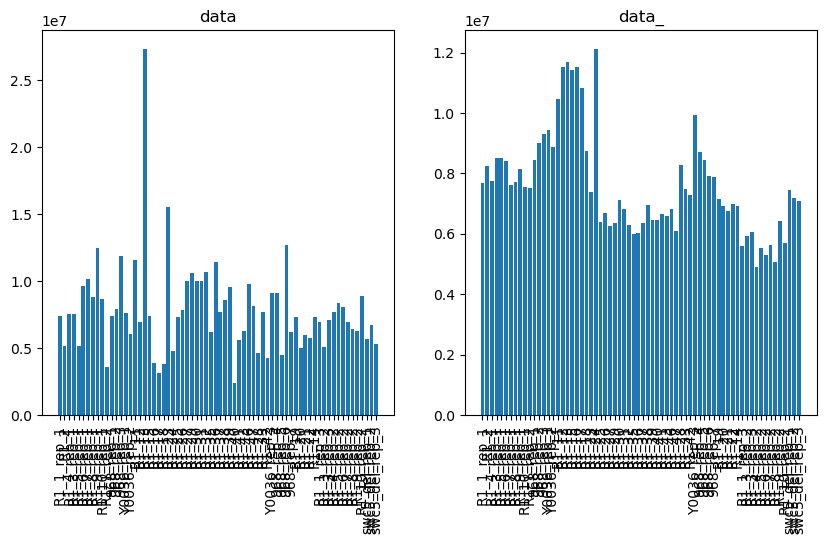

In [8]:
#plot the column totals in data and in data_
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(len(col_names)),np.sum(data,axis=0))
plt.xticks(range(len(col_names)),col_names,rotation=90)
plt.title('data')
plt.subplot(1,2,2)
plt.bar(range(len(col_names)),np.sum(data_,axis=0))
plt.xticks(range(len(col_names)),col_names,rotation=90)
plt.title('data_')
plt.show()


In [9]:
#import washing phenotypes /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Celeste's original code/QTL mapping/washing_phenotypes.csv
washing = pd.read_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/phenotype_s.csv',header=0,index_col=0)
#keep first two cols
washing = washing.iloc[:,:2]
washing.columns = ['genotype','phenotype']
#import filtering phenotypes /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Celeste's original code/QTL mapping/filtering_phenotypes.csv
filtering = pd.read_csv('/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Celeste original code/QTL mapping/filtering_phenotypes.csv',header=0,index_col=0)
filtering.columns = ['genotype','phenotype']
#merge the two dataframes by genotype, and name the phenotypes washing and filtering
phenotypes = pd.merge(washing,filtering,on='genotype')
phenotypes.columns = ['genotype','washing','filtering']

In [10]:
#create an array called genotypes_to_retain, which has the entries from true_genotypes removing _rep_1 and _rep_2
genotypes_to_retain = [i.split('_rep_')[0] for i in true_genotypes]
#only retain the ones that are in the phenotypes dataframe
genotypes_to_retain = [i for i in genotypes_to_retain if i in phenotypes.genotype.values]
#subset col_names to include only the genotypes that are in genotypes_to_retain, or those + _rep_...
col_names_retained = [i for i in col_names if i in genotypes_to_retain or i.split('_rep_')[0] in genotypes_to_retain]
#index of which col_names were retained
ind = [i in col_names_retained for i in col_names]
#subset the data to only include the genotypes in genotypes_to_retain in the same order
data_full = data_.copy()
data_ = data_[:,ind]

#subset the phenotypes to only include the genotypes in genotypes_to_retain
#phenotypes = phenotypes[[i in genotypes_to_retain for i in phenotypes.genotype]]

In [11]:
col_names_retained_wo_reps = [i.split('_rep_')[0] for i in col_names_retained]
import scipy.stats as st
#create a new df for phenotypes with reordering phenotypes such that genotype matches the order of those in col_names_retained_wo_reps
phenotypes_ = pd.DataFrame(columns=['genotype','washing','filtering'])
for i in col_names_retained_wo_reps:
    phenotypes_ = phenotypes_.append(phenotypes.loc[phenotypes.genotype==i,:])
phenotypes_.index = range(len(phenotypes_))
phenotypes_
#extrac the two phenotypes as arrays from the df
washing = phenotypes_['washing'].values
filtering = phenotypes_['filtering'].values


def find_correlated_genes(data,phenotype, only_sig=True, add_function=True,systematic_names=systematic_names ):
    df = pd.DataFrame(columns=['gene','correlation','p-value'])
    with warnings.catch_warnings():
        for i in range(data.shape[0]):
            cor = st.spearmanr(data[i,:],phenotype)[:2]
            df = df.append({'gene':ind_names[i],'correlation':cor[0],'p-value':cor[1],"systematic_names":systematic_names[i]},ignore_index=True)
    #remove every row that has NaN for p-value
    df = df.dropna(subset=['p-value'])
    #perform BH correction

    df['p-value adj'] = smm.fdrcorrection(df['p-value'])[1]
    #order by p-value
    df = df.sort_values(by='p-value')
    #only retain significant ones
    if only_sig:
        df = df[df['p-value adj']<0.05]
    #for each gene add the function (column 4 in gene_desc)
    if add_function:
        #find the row in gene_desc where the gene name matches either the entry in column 0 or 2
        #add the function from column 4 to the df
        df['function'] = [gene_desc.loc[(gene_desc[0]==i) | (gene_desc[2]==i),4].to_string(index=False)  for i in df.gene]
        #if entry in function is 'Series([], )' then replace with 'unknown'
        df['function'] = [i if i!='Series([], )' else 'unknown' for i in df['function']]
        #if gene name has -antisense- in it, then look for what is after that, and see if it has a function
        #if it does, then add that function to the df
        df["sense function"] = df["function"]
        for i in range(df.shape[0]):
            if '-antisense-' in df.gene.values[i]:
                #find the gene name before -antisense-
                gene_name = df.gene.values[i].split('-antisense-')[0]
                #find the function of that gene
                function = gene_desc.loc[(gene_desc[0]==gene_name) | (gene_desc[2]==gene_name),4].to_string(index=False)
                #if the function is not 'Series([], )' then add it to the df
                if function!='Series([], )':
                    df['sense function'].values[i] = function
                else:
                    df['sense function'].values[i] = 'unknown'

    return df


In [12]:
with warnings.catch_warnings():
    wash_df = find_correlated_genes(data_,washing,only_sig=False)
    filt_df = find_correlated_genes(data_,filtering,only_sig=False)
    

Text(0.5, 1.0, 'Correlation of gene expression with washing phenotype')

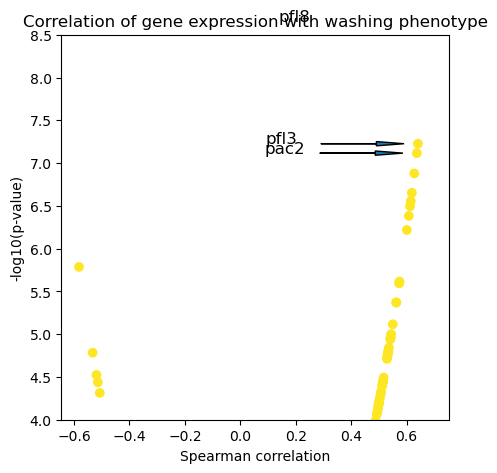

In [13]:
#create volcano plot for wash_df color hits above bonferroni threshold
#create large figure
plt.figure(figsize=(5,5))
plt.scatter(wash_df['correlation'],-np.log10(wash_df['p-value']),c=wash_df['p-value adj']<0.05)
#label top 3 hits with gene name left of the gene and arrow pointing to the gene
for i in range(3):
    plt.text(wash_df['correlation'].values[i]-0.55,-np.log10(wash_df['p-value'].values[i]),wash_df['gene'].values[i],fontsize=12)
    plt.arrow(wash_df['correlation'].values[i]-0.35,-np.log10(wash_df['p-value'].values[i]),0.2,0,head_width=0.05,head_length=0.1)
#show figure from 4 upwards
plt.ylim(4,8.5)
plt.xlabel('Spearman correlation')
plt.ylabel('-log10(p-value)')
plt.title('Correlation of gene expression with washing phenotype')


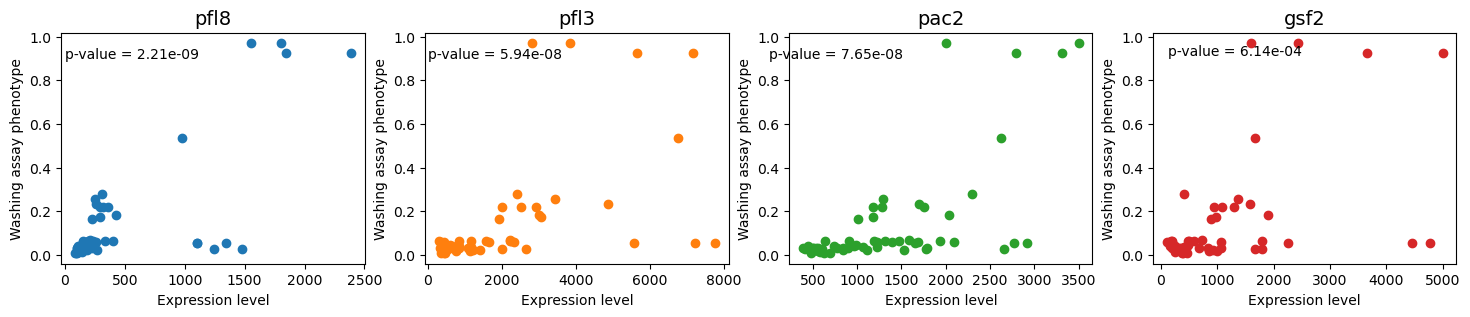

In [14]:
#create publication quality plots side by side for the top 3 genes and gsf2 vs washing. Use different colors and nice fonts. 

fig,ax = plt.subplots(1,4,figsize=(18,3))
for i,col in zip(range(4),['#1f77b4','#ff7f0e','#2ca02c', '#d62728']):
    if i==3:
        ax[i].scatter(data_[ind_names=='gsf2',:],washing,c=col)
        ax[i].set_title("gsf2",fontsize=14)
        ax[i].set_xlabel('Expression level',fontsize=10)
        ax[i].set_ylabel('Washing assay phenotype',fontsize=10)
        
        ax[i].tick_params(labelsize=10)
        #put p-value from wash_df p-value column to 2 significant figures in scientific notation
        ax[i].text(0.05,0.9,'p-value = {:.2e}'.format(wash_df['p-value'].values[wash_df["gene"]=="gsf2"][0]),transform=ax[i].transAxes,fontsize=10)
    else:
        ax[i].scatter(data_[ind_names==wash_df.gene.values[i],:],washing,c=col)
    
        

        ax[i].set_title(wash_df.gene.values[i],fontsize=14)
        ax[i].set_xlabel('Expression level',fontsize=10)
        ax[i].set_ylabel('Washing assay phenotype',fontsize=10)
        
        ax[i].tick_params(labelsize=10)
        #put p-value from wash_df p-value column to 2 significant figures in scientific notation
        ax[i].text(0.05,0.9,'p-value = {:.2e}'.format(wash_df['p-value'].values[i]))

    
    


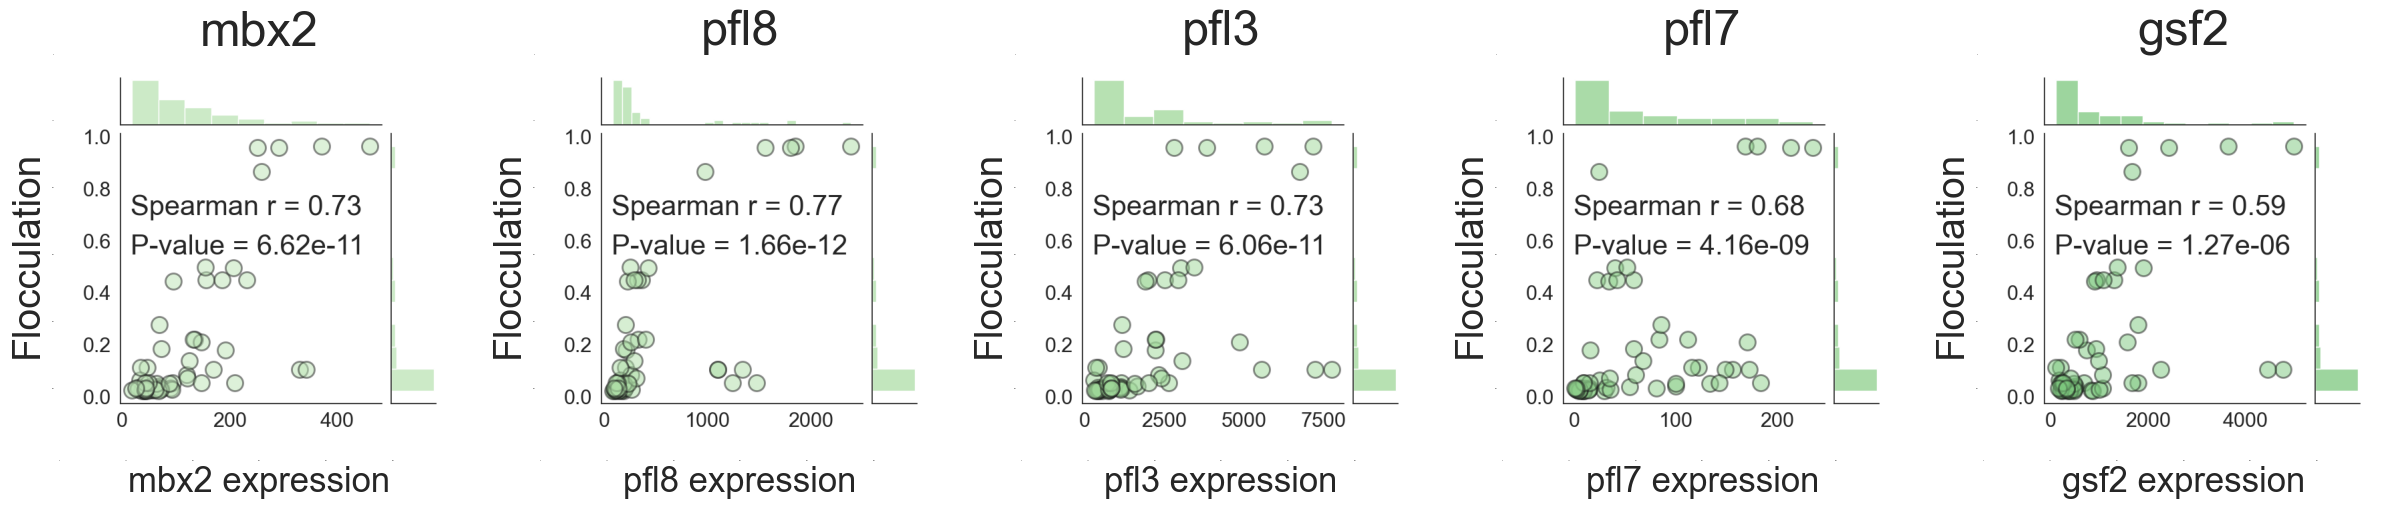

In [55]:
colors = sns.color_palette("Greens", 20)
#put 5 of these in a row by saving them as images and the using the image function in matplotlib
for i,j,col in zip(range(5),["mbx2","pfl8",  "pfl3","pfl7","gsf2"],colors[5:]):
    plt.figsize=(10,10)
    #large glyph with alpha transparency
    #strong thick edges for circles
    sns.set_style("white", {'axes.grid' : False})
    sns.despine()
    sns.jointplot(data_[ind_names==j,:][0],filtering,kind='scatter',color=col, alpha=0.5,s=300,edgecolor='k',linewidth=2)
    #axis
    sns.set(font_scale=2)
    plt.xlabel('mbx2 expression level')
    #add p value
    #larger numbers next to the axis
    sns.set_style("white", {'axes.grid' : False})
    sns.despine()
    

#print corr coef
    plt.text(-230,0.7,'Spearman r = {:.2f}'.format(st.spearmanr(data_[ind_names==j,:][0],filtering)[0]),fontsize=30)
    plt.text(-230,0.55,'P-value = {:.2e}'.format(st.spearmanr(data_[ind_names==j,:][0],filtering)[1]),fontsize=30)
    plt.savefig('jointplot{}.png'.format(i))
    plt.close()
    
for i,j in zip(range(5),["mbx2","pfl8",  "pfl3","pfl7","gsf2"]):
    #load them and arange in one big plot
    
    plt.subplot(1,5,i+1)
    #read big figure
    plt.imshow(plt.imread('jointplot{}.png'.format(i)))
    #increase size
    plt.gcf().set_size_inches(30,30)
    plt.title(["mbx2","pfl8",  "pfl3","pfl7","gsf2"][i],fontsize=35)
    plt.axis('off')
    plt.axis('on')
    plt.ylabel('Flocculation',fontsize=28)
    plt.xlabel('{} expression'.format(j),fontsize=25)
    #remove ticks
    plt.tick_params(labelsize=0)
    #remove frame
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    #remove the ticks of the outer frame
    plt.gca().tick_params(axis='both', which='both', length=0)
  


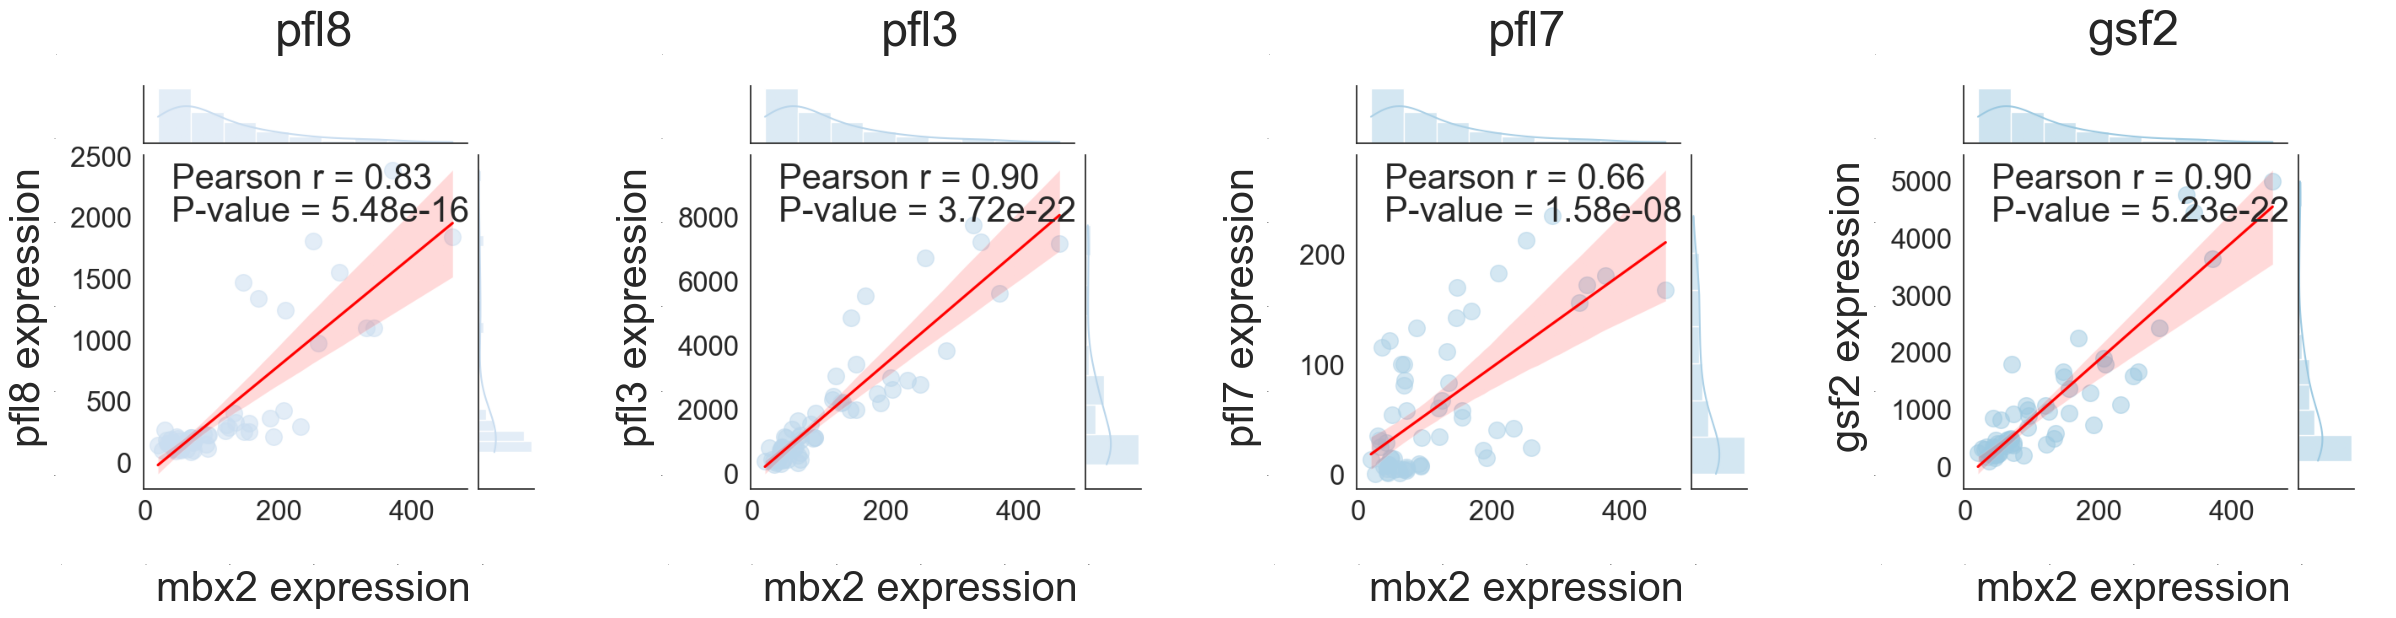

In [62]:
colors = sns.color_palette("Blues", 20)
#put 5 of these in a row by saving them as images and the using the image function in matplotlib
for i,j,col in zip(range(4),["pfl8",  "pfl3","pfl7","gsf2"],colors[4:]):
    plt.figsize=(10,10)
    sns.set_style("white", {'axes.grid' : False})
    sns.despine()
    #large glyph with alpha transparency
    sns.jointplot(data_[ind_names=='mbx2',:][0],data_[ind_names==j,:][0],kind='reg',color=col,joint_kws={'line_kws':{'color':'red'}},scatter_kws={'alpha':0.5,'s':200})
    #axis
    plt.xlabel('mbx2 expression level')
    sns.set(font_scale=2.15)
    sns.set_style("white", {'axes.grid' : False})
    sns.despine()
    #add p value
    #larger numbers next to the axis
    

#print corr coef
    plt.text(-5.5,0.9,'Pearson r = {:.2f}'.format(st.pearsonr(data_[ind_names==j,:][0],data_[ind_names=='mbx2',:][0])[0]),transform=plt.gca().transAxes,fontsize=30)
    plt.text(-5.5,0.8,'P-value = {:.2e}'.format(st.pearsonr(data_[ind_names==j,:][0],data_[ind_names=='mbx2',:][0])[1]),transform=plt.gca().transAxes,fontsize=30)
    plt.ylabel('{} expression level'.format(j))
    plt.savefig('jointplot{}.png'.format(i))
    plt.close()
    
for i,j in zip(range(4),["pfl8",  "pfl3","pfl7","gsf2"]):
    #load them and arange in one big plot
    
    plt.subplot(1,4,i+1)
    #read big figure
    plt.imshow(plt.imread('jointplot{}.png'.format(i)))
    #increase size
    plt.gcf().set_size_inches(30,30)
    plt.title(["pfl8",  "pfl3","pfl7","gsf2"][i],fontsize=35)
    plt.axis('off')
    plt.axis('on')
    plt.xlabel('mbx2 expression',fontsize=30)
    plt.ylabel('{} expression'.format(j),fontsize=30)
    #remove ticks
    plt.tick_params(labelsize=0)
    #remove frame
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    #remove the ticks of the outer frame
    plt.gca().tick_params(axis='both', which='both', length=0)
    
    

In [38]:
#remove entries in filt_df where systematinc_names starts with SPNCRNA
filt_df = filt_df[~filt_df.systematic_names.str.startswith('SPNCRNA')]
#reindex
filt_df = filt_df.reset_index(drop=True)
filt_df

,gene,correlation,p-value,systematic_names,p-value adj,function,sense function
0,pfl8,0.769704,1.658823e-12,SPAC1F8.06,1.102288e-08,"cell surface glycoprotein, flocculin Pfl8","cell surface glycoprotein, flocculin Pfl8"
1,pfl3,0.733027,6.056226e-11,SPBC947.04,1.465479e-07,"cell surface glycoprotein, flocculin Pfl3, DIP...","cell surface glycoprotein, flocculin Pfl3, DIP..."
2,mbx2,0.732042,6.616158e-11,SPBC317.01,1.465479e-07,"DNA-binding transcription factor, MADS-box Pvg4","DNA-binding transcription factor, MADS-box Pvg4"
3,pfl7,0.680595,4.161536e-09,SPBC359.04c,6.913352e-06,"cell surface glycoprotein, flocculin Pfl7, DIP...","cell surface glycoprotein, flocculin Pfl7, DIP..."
4,pac2,0.664503,1.287229e-08,SPAC31G5.11,1.425607e-05,cAMP-independent regulatory protein Pac2,cAMP-independent regulatory protein Pac2
...,...,...,...,...,...,...,...
5110,smb1,-0.000400,9.976223e-01,SPAC26A3.08,9.982232e-01,Sm snRNP core protein Smb1,Sm snRNP core protein Smb1
5111,mis17,-0.000369,9.978052e-01,SPBC21.01,9.982559e-01,CENP-U ortholog Mis17,CENP-U ortholog Mis17
5112,rna14,0.000123,9.992684e-01,SPAC6F12.17,9.995692e-01,mRNA cleavage and polyadenylation specificity ...,mRNA cleavage and polyadenylation specificity ...
5113,tah18,-0.000062,9.996342e-01,SPAC1296.06,9.997847e-01,CIA machinery NADPH-dependent diflavin oxidore...,CIA machinery NADPH-dependent diflavin oxidore...


In [64]:
#check where is pho1
wash_df[wash_df.gene=='inv1']

,gene,correlation,p-value,systematic_names,p-value adj,function,sense function
4631,inv1,0.265758,0.043767,SPCC191.11,0.294236,"external invertase, beta-fructofuranosidase Inv1","external invertase, beta-fructofuranosidase Inv1"


In [40]:
#save 5 databases
#correlated with wash
wash_df.to_csv('wash_corr.csv')
#correlated with filter
filt_df.to_csv('filter_corr.csv')


NameError: name 'mbx2_corr' is not defined

In [65]:
#import /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/updated_genotype_matrix_final_pos.tsv
snps = pd.read_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/updated_genotype_matrix_final_pos.tsv", sep="\t")

snps = snps[(snps["position"]==2316851)]
#remove first 4 columns
snps = snps.iloc[:,4:]

In [66]:

snps.reset_index(drop=True, inplace=True)
#snps now contains the genotypes at II:2316554
#remove columns with NaNs
for i in snps.columns:
    if (snps[i].isna().any()):
        snps = snps.drop(i,axis=1)

genotype = snps.loc[0].values
   
index_0= snps.columns[genotype==0]
colnames_0 = snps.columns[genotype==0]
index_1= snps.columns[genotype==1]
colnames_1 = snps.columns[genotype==1]
#iterate through enumerate col_names_retained_wo_reps and save the index of the column names in col_index_0 and col_index_1 deoendibgn on genotype
col_index_0 = []
col_index_1 = []
for i in enumerate(col_names_retained_wo_reps):
      if (i[1] in colnames_0):
            col_index_0.append(i[0])
      elif (i[1] in colnames_1):
            col_index_1.append(i[0])


In [67]:
df = pd.DataFrame(columns=["gene","mean_exp_0","mean_exp_1","log2fc","pval","pval_adjust"])
for i in ind_names:
    #get expression of gene i
      gene_exp = data_[ind_names==i,:]
    
      gene_exp_0 = gene_exp[0,col_index_0]
      gene_exp_1 = gene_exp[0,col_index_1]


    #calculate mean expression of gene i for genotype 0
      mean_exp_0 = np.mean(gene_exp_0)
    #calculate mean expression of gene i for genotype 1
      mean_exp_1 = np.mean(gene_exp_1)
    #clculate log2fc
      log2fc = np.log2(mean_exp_1/mean_exp_0)
    #calculate pval
      pval = st.ttest_ind(gene_exp_0,gene_exp_1)[1]
      pval_adjust = pval*len(ind_names)
    #add to df
      df = df.append({"gene":i,"mean_exp_0":mean_exp_0,"mean_exp_1":mean_exp_1,"log2fc":log2fc,"pval":pval,"pval_adjust":pval_adjust},ignore_index=True)
      #print progress
      

df

,gene,mean_exp_0,mean_exp_1,log2fc,pval,pval_adjust
0,mrx11,57.617070,54.117961,-0.090389,0.533449,3593.845448
1,pom34,325.054398,378.547900,0.219795,0.002966,19.983366
2,gls2,2209.524993,2286.559272,0.049442,0.654670,4410.514551
3,taf11,249.580829,270.697743,0.117176,0.170391,1147.924010
4,jmj2,181.729259,161.280116,-0.172222,0.020973,141.297336
...,...,...,...,...,...,...
6732,SPNCRNA.995,62.768791,48.368085,-0.375992,0.059930,403.748477
6733,SPNCRNA.996,47.459613,39.531281,-0.263706,0.179258,1207.659531
6734,SPAC637.04-antisense-1,7.095791,12.051077,0.764127,0.072257,486.792644
6735,SPNCRNA.998,23.213323,28.221166,0.281825,0.093661,630.995969


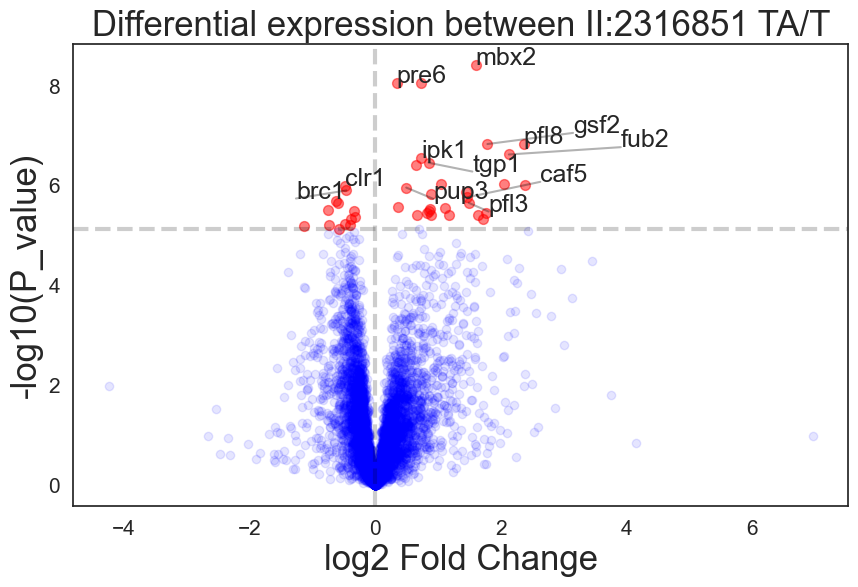

In [69]:
#sort based on pval_adjust
df = df.sort_values(by="pval_adjust")
df.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Differential expression between II:2316851 TA/T",fontsize=25)
ax.set_xlabel("log2 Fold Change",fontsize=25)
ax.set_ylabel("-log10(P_value)",fontsize=25)
for i in df.index:
      if (df.loc[i,"pval_adjust"]<0.05):
            ax.scatter(df.loc[i,"log2fc"],-np.log10(df.loc[i,"pval"]),c='red',alpha=0.5,s=50)
      else:
            ax.scatter(df.loc[i,"log2fc"],-np.log10(df.loc[i,"pval"]),c='blue',alpha=0.1)
#plot a horizontal line at -log10(0.05)
#bonferroni correction
bonf=0.05/len(df)
ax.axhline(y=-np.log10(bonf),color='black',linestyle='--', alpha=0.1, linewidth=3)

#plot a vertical line at log2fc=0
ax.axvline(x=0,color='black',linestyle='--', alpha=0.1, linewidth=3)
#plot a horizontal line at -log10(0.05)
ax.axhline(y=-np.log10(bonf),color='black',linestyle='--', alpha=0.1, linewidth=3)
#plot a vertical line at log2fc=0
ax.axvline(x=0,color='black',linestyle='--', alpha=0.1, linewidth=3)
#annotate top 10 genes with their names and make sure these dont overlap. To do this make a matrix of their coordinates and make sure they are far enough apart
matrix = np.zeros((20,2))

for k in range(20):
     
      x = df.loc[k,"log2fc"]
      y = -np.log10(df.loc[k,"pval"])
      
      while (np.min(np.sqrt((matrix[:,0]-x)**2+(matrix[:,1]-y)**2))<0.8):
            #random walk
            if x<0:
                  x = x + np.random.normal(-0.05,0.05)
            else:
                  x = x + np.random.normal(0.05,0.05)
            y = y + np.random.normal(0,0.05)
      
      #if df.loc[k,"gene"] is less than 5 characters long, annotate it 0.1 above the point
      if (len(df.loc[k,"gene"])<5):
            ax.annotate(df.loc[k,"gene"],(x,y),fontsize=18)
            ax.plot([x,df.loc[k,"log2fc"]],[y,-np.log10(df.loc[k,"pval"])],color='black',alpha=0.3)
      else:
            x=x+1000
            y=y+1000
      matrix[k,0] = x
      matrix[k,1] = y
#increase fontsize of axis labels and title
ax.tick_params(labelsize=15)



    


In [ ]:
#save df as srb11_diff_exp.csv
df.to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/srb11_diff_exp.csv")

In [ ]:
#angeli for flocclation genes
filt_df_genes = filt_df[["systematic_names","p-value adj"]]
sig_genes = filt_df_genes[filt_df_genes["p-value adj"]<0.05]["systematic_names"].values
background_genes = filt_df_genes["systematic_names"].values
#export to this folder /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli
sig_genes = pd.DataFrame(sig_genes)
sig_genes.to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli/sig_genes.csv",index=False)
background_genes = pd.DataFrame(background_genes)
background_genes.to_csv("/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Angeli/background_filt_genes.txt",index=False)